#### source: https://min-api.cryptocompare.com/documentation

In [1]:
import os
from typing import Optional, Sequence
import pandas as pd
class CryptoCompareReader:
    # TODO drop last
    def __init__(self, crypto_name, folder: str, drop_na_subset: Optional[Sequence[str]] = None, add_time_columns=True):
        self.crypto_name = crypto_name
        self.folder = folder
        self.drop_na_subset = drop_na_subset
        self.add_time_columns = add_time_columns

    def _add_time_columns(self, all_info: pd.DataFrame) -> pd.DataFrame:
        all_info['time'] = pd.to_datetime(all_info['time'])
        all_info['dayOfTheWeek'] = all_info['time'].dt.dayofweek
        all_info['monthOfTheYear'] = all_info['time'].dt.month

        return all_info

    def read(self) -> pd.DataFrame:
        prices = pd.read_csv(os.path.join(self.folder, f"{self.crypto_name}_prices.csv"), thousands=',')
        blockchain_data = pd.read_csv(os.path.join(self.folder, f"{self.crypto_name}_blockchain_data.csv"),
                                      thousands=',')
        social = pd.read_csv(os.path.join(self.folder, f"{self.crypto_name}_social.csv"), thousands=',')

        all_info = prices \
            .merge(blockchain_data, on='time', how='outer') \
            .merge(social, on='time', how='outer') \
            .sort_values('time') \
            .reset_index(drop=True)
        if self.drop_na_subset:
            all_info.dropna(subset=self.drop_na_subset, inplace=True)

        if self.add_time_columns:
            all_info = self._add_time_columns(all_info)

        all_info.reset_index(drop=True, inplace=True)

        return all_info

In [2]:
raw_df = CryptoCompareReader('btc','../cryptoCompareData',drop_na_subset=['close']).read()
raw_df.head()

,time,high,low,open,close,BTCTradedToUSD,USDTradedToBTC,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,...,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,dayOfTheWeek,monthOfTheYear
0,2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902,34727.0,86979.0,447.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,7
1,2010-07-18,0.08585,0.05941,0.04951,0.08584,75.01,5.0920,35257.0,87446.0,467.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,7
2,2010-07-19,0.09307,0.07723,0.08584,0.08080,574.00,49.6600,35744.0,88051.0,605.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7
3,2010-07-20,0.08181,0.07426,0.08080,0.07474,262.00,20.5900,36257.0,88725.0,674.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7
4,2010-07-21,0.07921,0.06634,0.07474,0.07921,575.00,42.2600,36679.0,89194.0,469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,7


# Some quick plots <a class="anchor" name="quick-plots"></a>

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
def plot_yearly(ax,time : pd.Series , target : pd.Series, title:str,label:str=None):
    sns.lineplot(x=time,y=target.values,ax=ax,label=label)
    ax.xaxis.set_major_locator(mdates.YearLocator(3))
    ax.set_title(title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

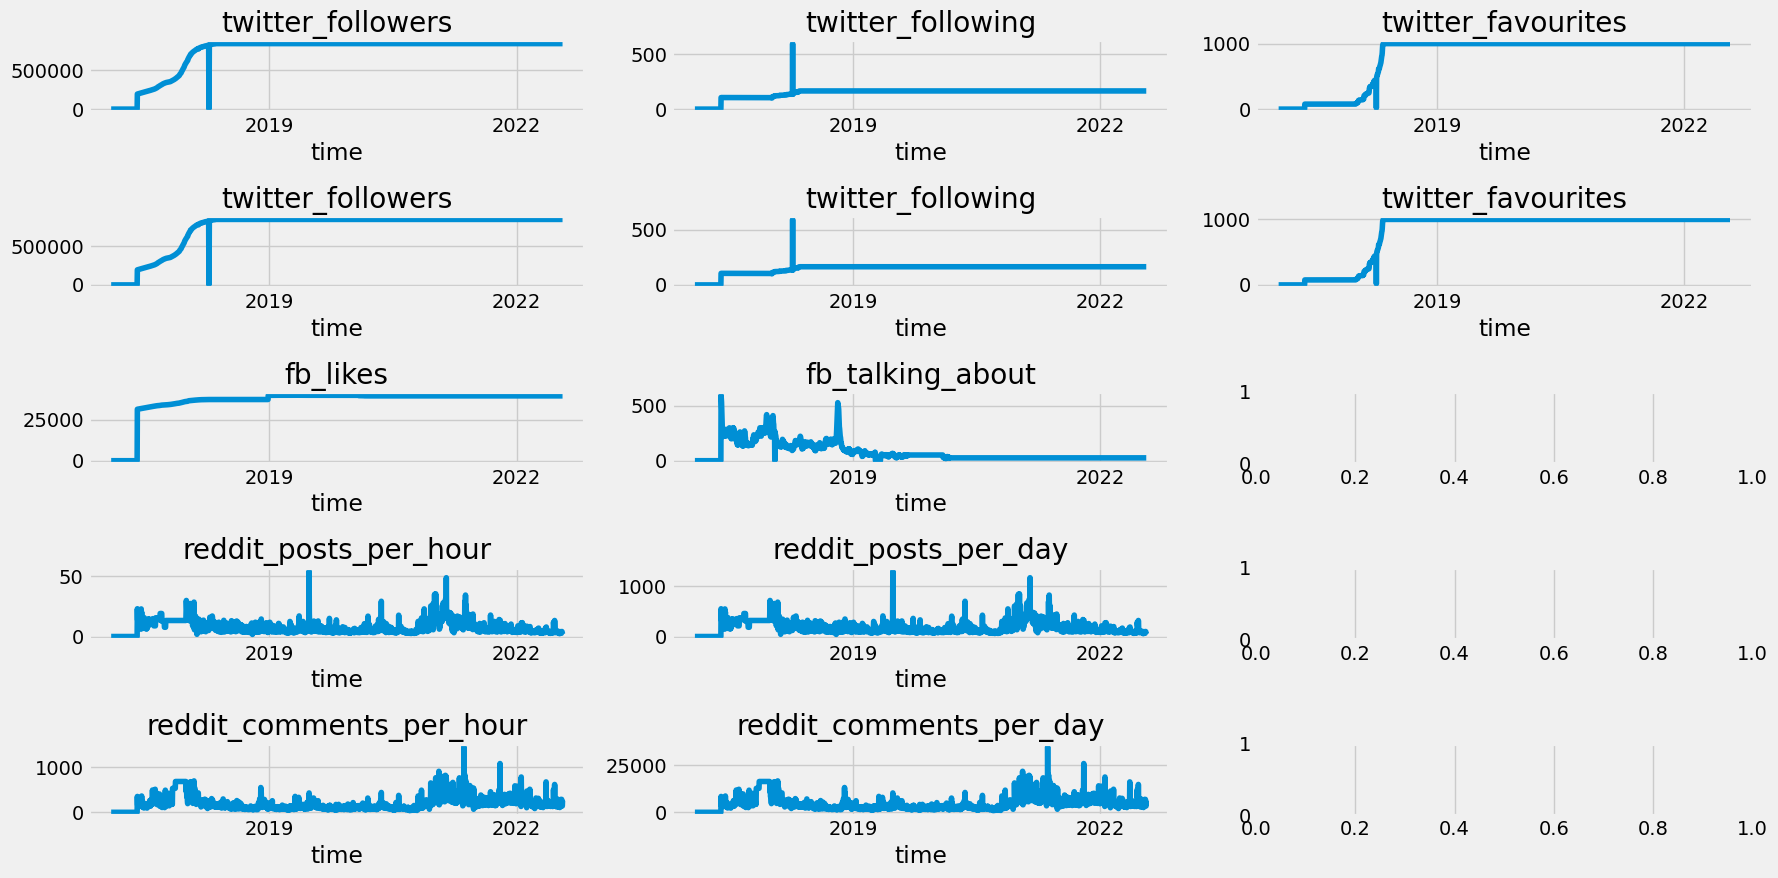

In [4]:
crypto_compare_columns = ['comments','posts','followers'] #crypto compares own site data, drop these
raw_df.drop(columns=crypto_compare_columns,inplace=True,errors='ignore')

fig,axes = plt.subplots(5,3,figsize=(18,9))

def plot_social_media(media_name,df,axes):
    for idx,col_name in enumerate(raw_df.filter(regex=media_name).columns):
        plot_yearly(axes[idx],df['time'],df[col_name],col_name)

plot_social_media('twitter_f',raw_df,axes[0])
plot_social_media('twitter_f',raw_df,axes[1])
plot_social_media('fb',raw_df,axes[2])
plot_social_media('reddit_posts',raw_df,axes[3])
plot_social_media('reddit_comments',raw_df,axes[4])
plt.tight_layout()

#### only reddit data seems legit, drop the other socials

In [5]:
df = raw_df.drop(columns = raw_df.filter(regex='twitter').columns.tolist(),errors='ignore')
df = df.drop(columns = df.filter(regex='fb_').columns.tolist(),errors='ignore')

spare_delta_columns = ['new_addresses','transaction_count'] #these columns are only delta values to others (all time addresses and all time trans count
df.drop(columns=spare_delta_columns,inplace=True,errors = 'ignore')

df.head(3)

,time,high,low,open,close,BTCTradedToUSD,USDTradedToBTC,zero_balance_addresses_all_time,unique_addresses_all_time,active_addresses,...,block_size,current_supply,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,dayOfTheWeek,monthOfTheYear
0,2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902,34727.0,86979.0,804.0,...,730.0,3439000.0,NaN,NaN,NaN,NaN,NaN,NaN,5,7
1,2010-07-18,0.08585,0.05941,0.04951,0.08584,75.01,5.0920,35257.0,87446.0,917.0,...,846.0,3447600.0,NaN,NaN,NaN,NaN,NaN,NaN,6,7
2,2010-07-19,0.09307,0.07723,0.08584,0.08080,574.00,49.6600,35744.0,88051.0,972.0,...,837.0,3456300.0,NaN,NaN,NaN,NaN,NaN,NaN,0,7


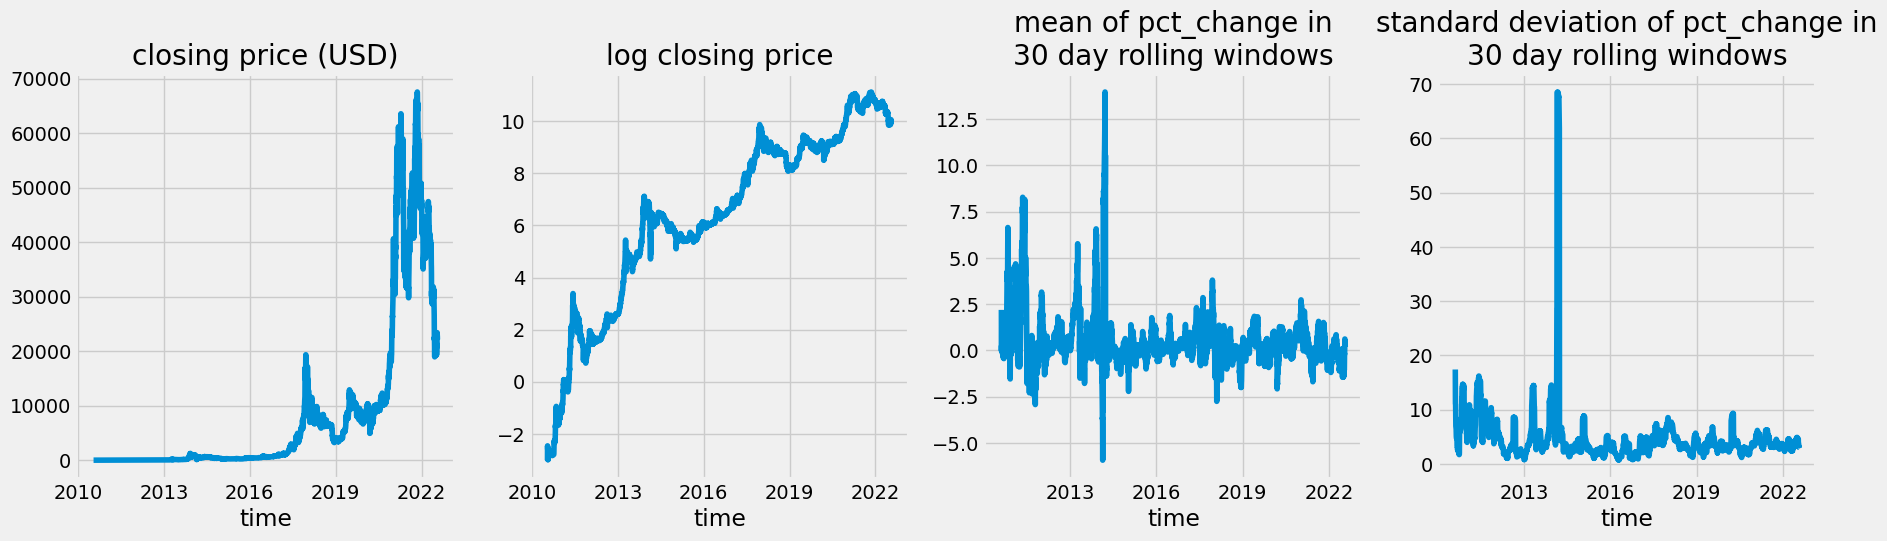

In [6]:
import numpy as np

rolling_window_size = 30

fig,axes = plt.subplots(1,4,figsize=(20,5))
plot_yearly(axes[0],df['time'],df['close'],'closing price (USD)')
plot_yearly(axes[1],df['time'],np.log(df['close']), 'log closing price')
plot_yearly(axes[2],df['time'],(df['close'].pct_change() * 100).rolling(30).mean(), f"mean of pct_change in\n{rolling_window_size} day rolling windows")
plot_yearly(axes[3],df['time'],(df['close'].pct_change() * 100).rolling(30).std(), f"standard deviation of pct_change in\n{rolling_window_size} day rolling windows")

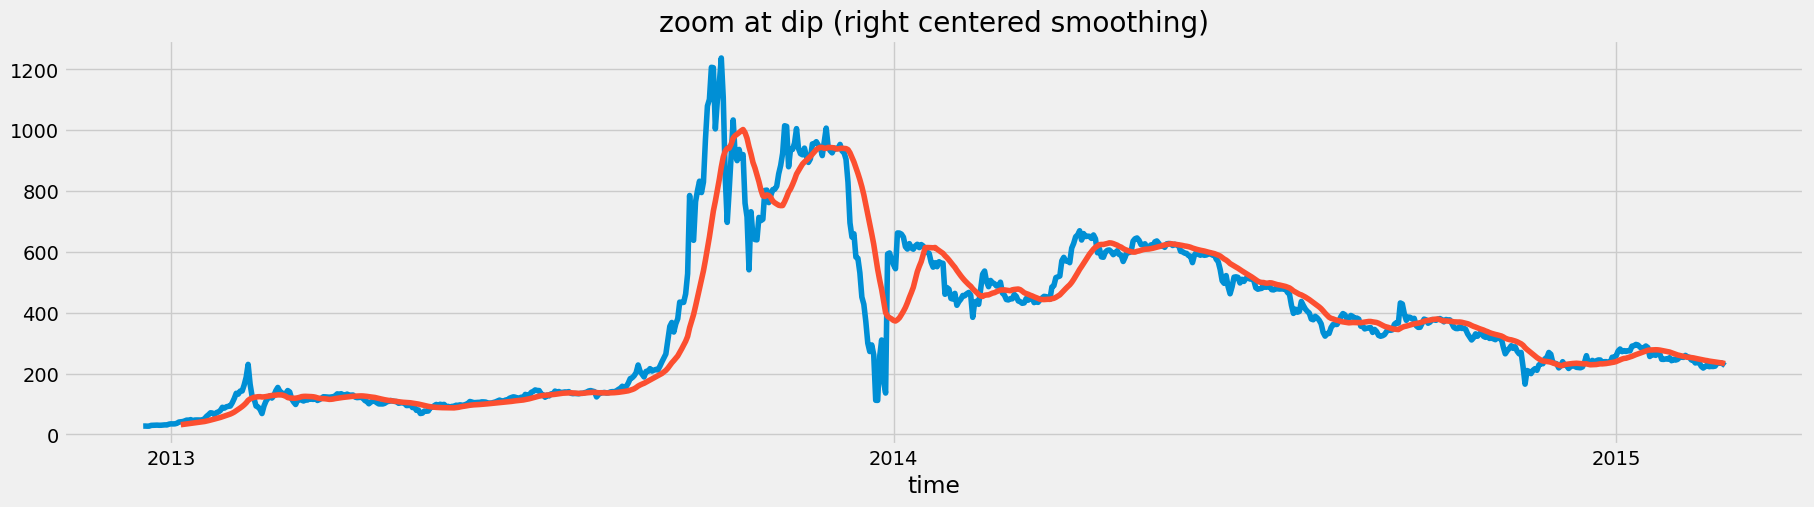

In [7]:
def plot_monthly(ax,time : pd.Series , target : pd.Series, title:str):
    sns.lineplot(x=time,y=target.values,ax=ax)
    ax.xaxis.set_major_locator(mdates.MonthLocator(3))
    ax.set_title(title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

jump_at = (df['close'].pct_change() * 100).rolling(30).mean().idxmax()
half_interval = 400
fig,ax = plt.subplots(1,1,figsize=(20,5))
plot_monthly(ax,df['time'].iloc[jump_at-half_interval:jump_at+half_interval],df['close'].iloc[jump_at-half_interval:jump_at+half_interval],'zoom at dip')
plot_monthly(ax,df['time'].iloc[jump_at-half_interval:jump_at+half_interval],df['close'].iloc[jump_at-half_interval:jump_at+half_interval].rolling(20).mean(),'zoom at dip (right centered smoothing)')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

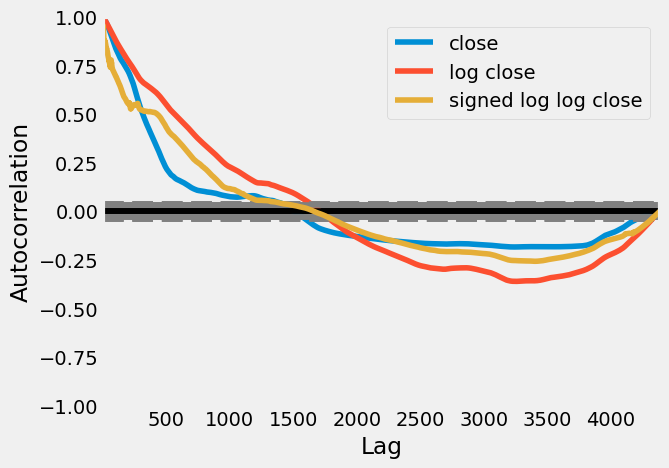

In [8]:
pd.plotting.autocorrelation_plot(df['close'],label='close')
pd.plotting.autocorrelation_plot(np.log(df['close']),label='log close')
loglog = np.log(np.abs(np.log(df['close']))+1e-8) * np.sign(np.log(df['close']))
pd.plotting.autocorrelation_plot(loglog,label='signed log log close')

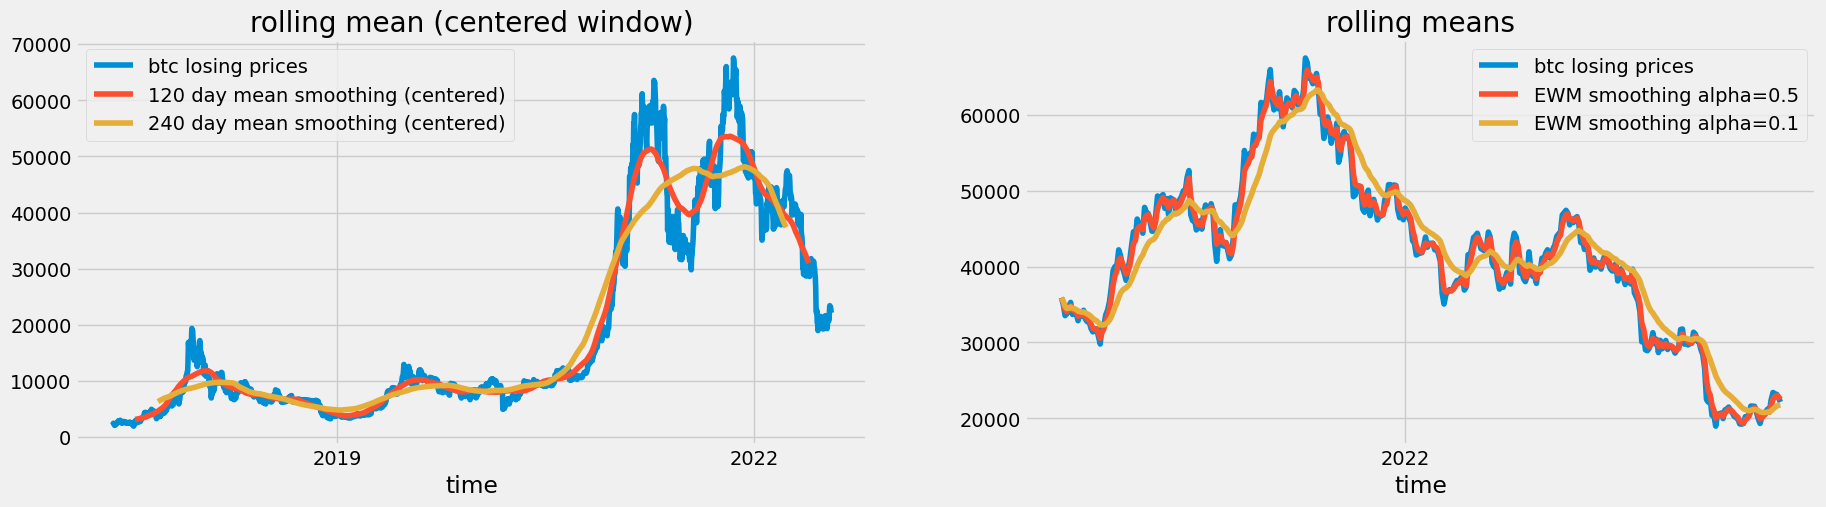

In [9]:
fig,axes = plt.subplots(1,2,figsize=(20,5))

axes[0].plot(df['time'].iloc[2500:],df['close'].iloc[2500:],label='btc losing prices')
for window in range(120,360,120):
    plot_yearly(axes[0],df['time'].iloc[2500:],df['close'].iloc[2500:].rolling(window,center=True).mean(),'rolling mean (centered window)',label=f'{window} day mean smoothing (centered)')

axes[0].legend()

axes[1].plot(df['time'].iloc[4000:],df['close'].iloc[4000:],label='btc losing prices')
plot_yearly(axes[1],df['time'].iloc[4000:],df['close'].iloc[4000:].ewm(alpha=0.5).mean(),'rolling means',label=f'EWM smoothing alpha=0.5')
plot_yearly(axes[1],df['time'].iloc[4000:],df['close'].iloc[4000:].ewm(alpha=0.1).mean(),'rolling means',label=f'EWM smoothing alpha=0.1')

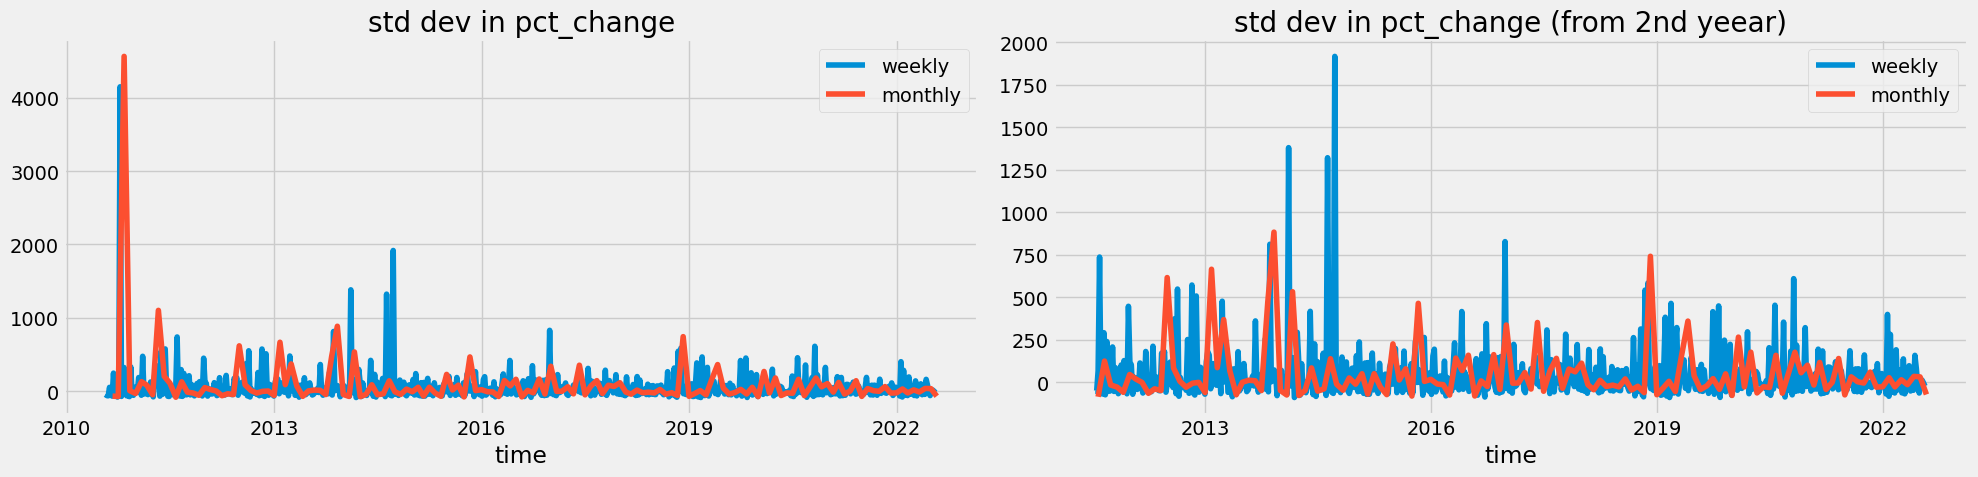

In [10]:
fig,axes = plt.subplots(1,2,figsize=(20,5))
weekly_std = df.groupby([pd.Grouper(key='time', freq='W')])['close']\
    .std()\
    .reset_index()\
    .sort_values('time')

monthly_std = df.groupby([pd.Grouper(key='time', freq='M')])['close']\
    .std()\
    .reset_index()\
    .sort_values('time')

log_weekly_mean = np.log(weekly_std['close'])
log_monthly_mean = np.log(monthly_std['close'])

plot_yearly(axes[0],weekly_std['time'],(weekly_std['close'].pct_change()*100),'std dev in pct_change',label='weekly')
plot_yearly(axes[0],monthly_std['time'],(monthly_std['close'].pct_change()*100), 'std dev in pct_change',label='monthly')

plot_yearly(axes[1],weekly_std['time'].iloc[52:],(weekly_std['close'].pct_change()*100).iloc[52:],'std dev in pct_change (from 2nd yeear)',label='weekly')
plot_yearly(axes[1],monthly_std['time'].iloc[12:],(monthly_std['close'].pct_change()*100).iloc[12:], 'std dev in pct_change (from 2nd yeear)',label='monthly')
axes[1].legend()
plt.tight_layout()

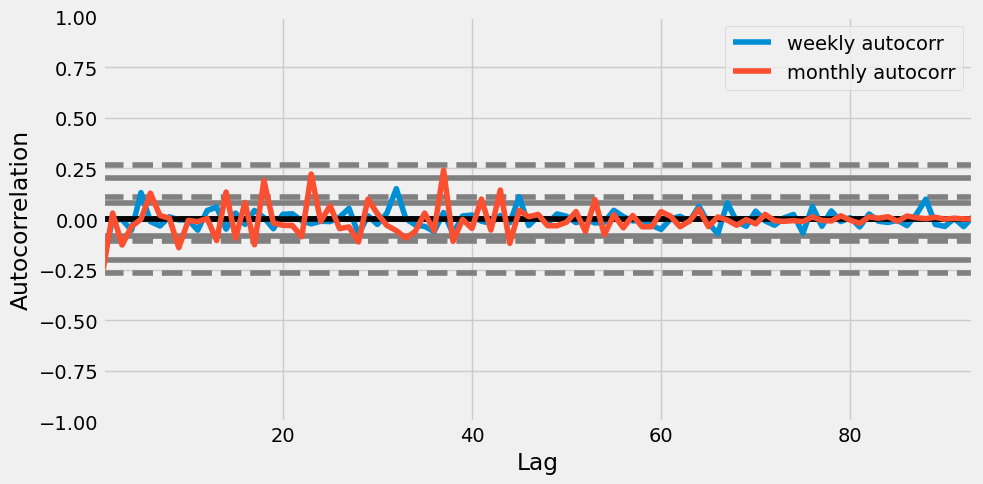

In [11]:
ax = pd.plotting.autocorrelation_plot((weekly_std['close'].pct_change()*100).iloc[52:],label='weekly autocorr')
ax = pd.plotting.autocorrelation_plot((monthly_std['close'].pct_change()*100).iloc[52:],label='monthly autocorr')
ax.figure.set_size_inches(10,5)

##### slight autocorr in both

<AxesSubplot:title={'center':'mean percent change in months'}, xlabel='time'>

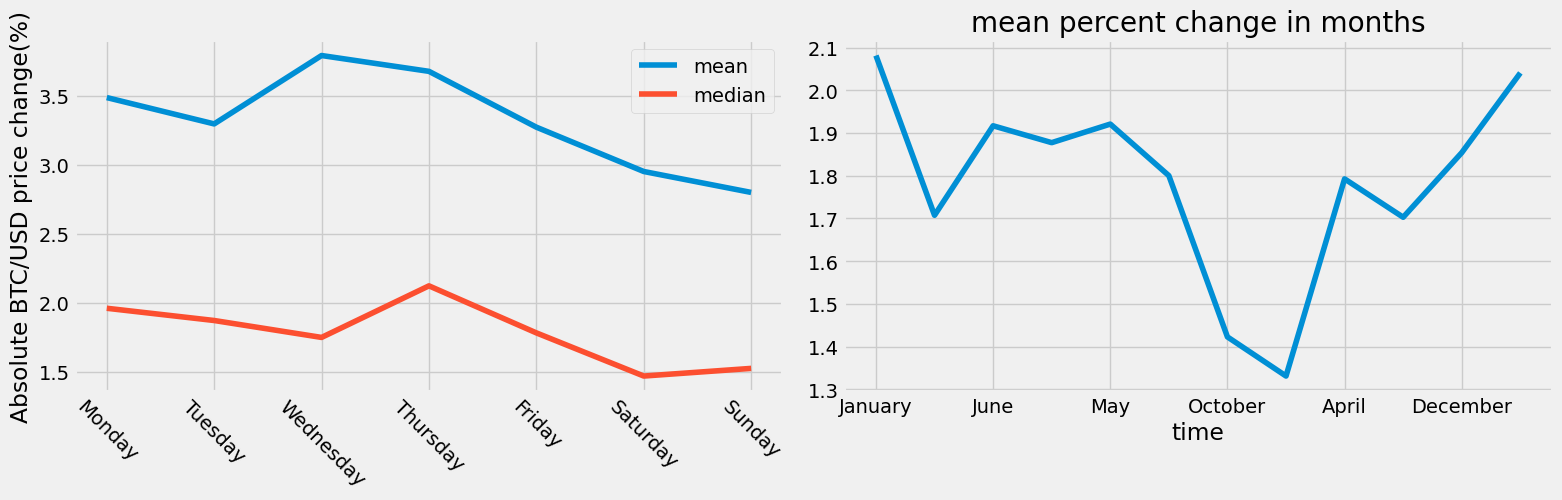

In [39]:
fig,axes = plt.subplots(1,2,figsize=(16,5))
df["close_pct_change"] = np.abs(df['close'].pct_change())*100

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
df.groupby(df['time'].dt.day_name())['close_pct_change'].mean().reindex(days).plot(ax=axes[0],label='mean',rot=-45)
df.groupby(df['time'].dt.day_name())['close_pct_change'].median().reindex(days).plot(ax=axes[0],label='median',rot=-45)
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('Absolute BTC/USD price change(%)')
axes[0].legend()
plt.tight_layout()
axes[0].figure.savefig('../documents/figures/daily_stats.png')

months = ["January","July","June","March","May","November","October","September","April","August","December","February"]
df.groupby(df['time'].dt.month_name())['close_pct_change'].median().reindex(months).plot(ax=axes[1],title='mean percent change in months')


In [16]:
df.groupby(df['time'].dt.day_name())['close_pct_change'].mean().reindex(days)

time
Monday       0.559152
Tuesday      0.594266
Wednesday    1.045956
Thursday     0.181853
Friday       0.405267
Saturday     0.512912
Sunday       0.230131
Name: close_pct_change, dtype: float64

In [15]:
df.groupby(df['time'].dt.day_name())['close_pct_change'].count().reindex(days)

time
Monday       627
Tuesday      627
Wednesday    627
Thursday     627
Friday       627
Saturday     627
Sunday       627
Name: close_pct_change, dtype: int64

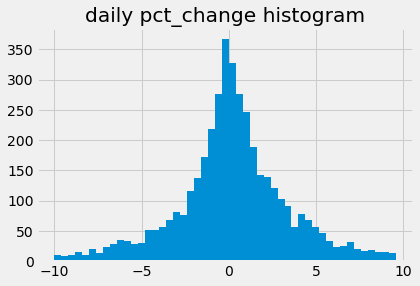

In [13]:
(df['close'].pct_change()*100).hist(bins=np.arange(-10,10,0.4))
plt.title('daily pct_change histogram');

In [12]:
from typing import List


def plot_scatters_against(against : pd.Series, xs : List[pd.Series], against_name : str, names : List[str]):
    cols = 3
    rows = int(np.ceil(len(names)/float(cols)))
    fig, axs = plt.subplots(rows,cols,figsize=(15,5*len(names) // 3))

    for idx,col_name in enumerate(names):
        row_idx = idx // cols
        col_idx = idx%cols
        if len(names) > 3:
            ax = axs[row_idx,col_idx]
        else:
            ax = axs[col_idx]
        ax.set_ylabel(against_name,fontsize=14)
        ax.scatter(xs[idx], against)
        ax.set_title(col_name  + f" corr:{round(against.corr(xs[idx]),3)}",fontsize=14)
        ax.set_xlabel(col_name,fontsize=14)
        fig.tight_layout()

    return fig,axs

In [15]:
def plot_log_comparison(series1 : pd.Series, series2 : pd.Series, name1 : str, name2 : str, smooth_only_first=True):
    fig, axs = plt.subplots(2,2, figsize=(10,10))

    log1 = np.log(series1)
    log2 = np.log(series2)

    axs[0][0].plot(series1, label=f'{name1}')
    axs[0][0].plot(series2, label=f'{name2}')
    axs[0][0].set_xlabel('time',fontsize=16)
    axs[0][0].set_title(f'corr : {round(series1.corr(series2),2)}')
    axs[0][0].legend()

    axs[0][1].plot(log1, label=f'log {name1}')
    axs[0][1].plot(log2, label=f'log {name2}')
    axs[0][1].set_xlabel('time',fontsize=16)
    axs[0][1].set_title(f'corr : {round(log1.corr(log2),2)}')
    axs[0][1].legend()

    axs[1][0].scatter(log1, log2)
    axs[1][0].set_xlabel('log transactions',fontsize=16)
    axs[1][0].set_ylabel('log closing prices',fontsize=16)

    smooth_corrs = []
    smoothing_values = [1] + [i*3 for i in range(1,100)]
    for s_f in smoothing_values:
        smooth1 = log1.rolling(window=s_f,center=False).mean()
        if not smooth_only_first:
            smooth2 = log2.rolling(window=s_f,center=False).mean()
        else:
            smooth2 = log2
        smooth_corrs.append(smooth1.corr(smooth2))

    axs[1][1].plot(smoothing_values,smooth_corrs)
    axs[1][1].set_xlabel('smoothing factor (over time points)',fontsize=16)
    axs[1][1].set_ylabel('correlations',fontsize=16)
    axs[1][1].set_title('smoothing vs correlations',fontsize=16)


    return fig, axs

In [16]:
df.head(3)

,time,high,low,open,close,BTCTradedToUSD,USDTradedToBTC,zero_balance_addresses_all_time,unique_addresses_all_time,active_addresses,...,current_supply,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,dayOfTheWeek,monthOfTheYear,close_pct_change
0,2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902,34727.0,86979.0,804.0,...,3439000.0,NaN,NaN,NaN,NaN,NaN,NaN,5,7,NaN
1,2010-07-18,0.08585,0.05941,0.04951,0.08584,75.01,5.0920,35257.0,87446.0,917.0,...,3447600.0,NaN,NaN,NaN,NaN,NaN,NaN,6,7,73.379115
2,2010-07-19,0.09307,0.07723,0.08584,0.08080,574.00,49.6600,35744.0,88051.0,972.0,...,3456300.0,NaN,NaN,NaN,NaN,NaN,NaN,0,7,-5.871389


# Raw correlations: <a class="anchor" id="raw-correlations"></a>

## market data <a class="anchor" name="market-data"></a>

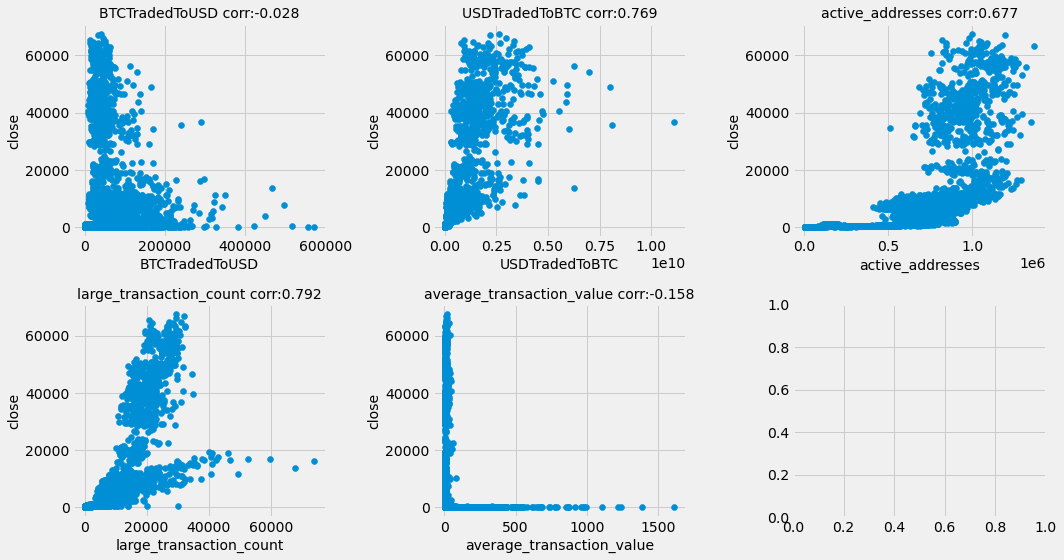

In [17]:
scatter_columns = ['BTCTradedToUSD','USDTradedToBTC','active_addresses','large_transaction_count','average_transaction_value']
scatter_series = [df[col] for col in scatter_columns]
fig,axes = plot_scatters_against(df['close'],scatter_series,'close',scatter_columns)

In [18]:
for col in scatter_columns:
    print(col,': corr',round(df['close'].corr(df[col]),2),' | log corr',round(np.log(df['close']).corr(np.log(df[col]+1e-8)),2))

BTCTradedToUSD : corr -0.03  | log corr 0.23
USDTradedToBTC : corr 0.77  | log corr 0.93
active_addresses : corr 0.68  | log corr 0.95
large_transaction_count : corr 0.79  | log corr 0.84
average_transaction_value : corr -0.16  | log corr -0.79


##### higher correlations with logarithm

### BTC Traded to USD <a class="anchor" name="btc-usd"></a>

BTCTradedToUSD_btc_prices 0.0 values:
     BTCTradedToUSD       time  dayOfTheWeek
338             0.0 2011-06-20             0
339             0.0 2011-06-21             1
340             0.0 2011-06-22             2
341             0.0 2011-06-23             3
342             0.0 2011-06-24             4
343             0.0 2011-06-25             5


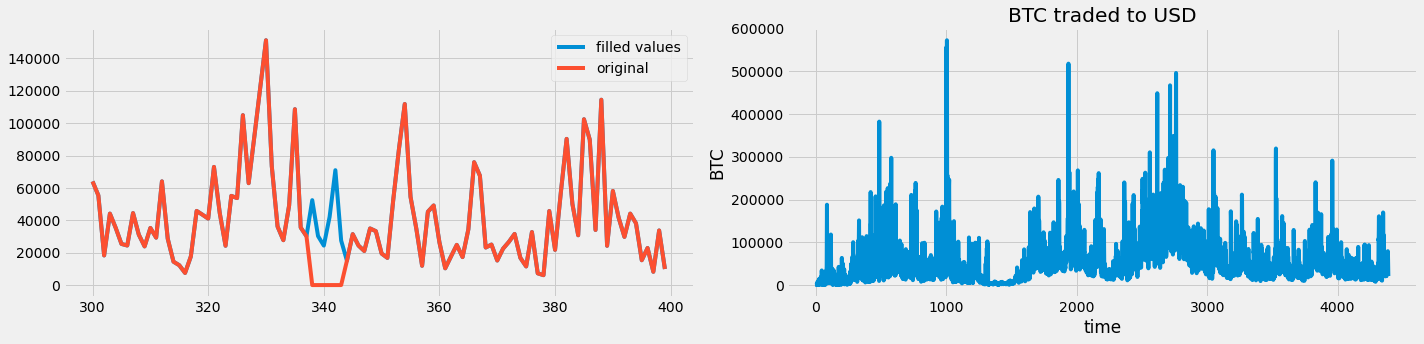

In [19]:
BTCTradedToUSD_btc_prices_nonnull = df["BTCTradedToUSD"].copy()
BTCTradedToUSD_btc_prices_nonnull.loc[df["BTCTradedToUSD"] == 0.0] \
    = (df["BTCTradedToUSD"].shift(7) + df["BTCTradedToUSD"].shift(-7))/2.0
#because we have 0.0 values for some reason in a period and cannot the logarithm
print('BTCTradedToUSD_btc_prices 0.0 values:')
print(df[['BTCTradedToUSD','time','dayOfTheWeek']].loc[df["BTCTradedToUSD"] == 0.0])

fig,axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(BTCTradedToUSD_btc_prices_nonnull.iloc[300:400],label='filled values')
axs[0].plot(df["BTCTradedToUSD"].iloc[300:400],label='original')
axs[0].legend(loc='upper right')

axs[1].plot(BTCTradedToUSD_btc_prices_nonnull)
axs[1].set_title('BTC traded to USD')
axs[1].set_xlabel('time')
axs[1].set_ylabel('BTC')
plt.tight_layout()

##### for some reason there are 0.0 values for this week,
##### filled in the week with the average of the next and previous weeks' days respectively for now

### large transaction count seems to be on '2 lines' <a class="anchor" name="large-trans"></a>:

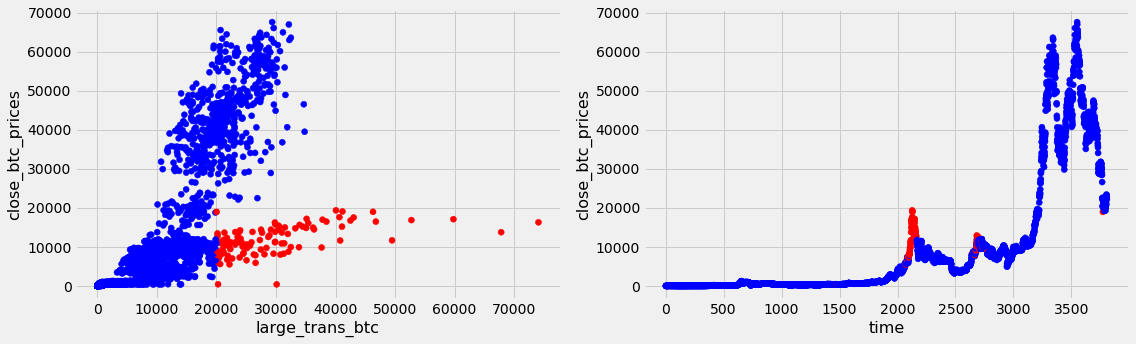

In [20]:
large_trans_btc = df['large_transaction_count']
large_trans_btc = large_trans_btc[large_trans_btc != 0] #in the first ~800 days this column is 0.0

corresponding_closing_btc_prices = df[['close']].loc[large_trans_btc.index].reset_index(drop=True)
btc_closing_under_20k = corresponding_closing_btc_prices.loc[corresponding_closing_btc_prices['close'] < 20000].index


large_trans_idx_reset = large_trans_btc.reset_index(drop=True)
large_trans_over_20k = large_trans_idx_reset.loc[large_trans_idx_reset > 20000].index

common_indices = [i for i in btc_closing_under_20k if i in large_trans_over_20k]
others = [i for i in btc_closing_under_20k if i not in large_trans_over_20k]

fig,axes = plt.subplots(1,2,figsize=(16,5))
colors = ['red' if i in common_indices else 'blue' for i in corresponding_closing_btc_prices.index]

axes[0].scatter(x=large_trans_btc,y=corresponding_closing_btc_prices['close'],color=colors)
axes[0].set_xlabel('large_trans_btc',fontsize=16)
axes[0].set_ylabel('close_btc_prices',fontsize=16)
axes[1].scatter(x=corresponding_closing_btc_prices.index,y=corresponding_closing_btc_prices['close'],color=colors)
axes[1].set_xlabel('time',fontsize=16)
axes[1].set_ylabel('close_btc_prices',fontsize=16)
plt.tight_layout();

### average_transaction_value- looks like the scales are not right:

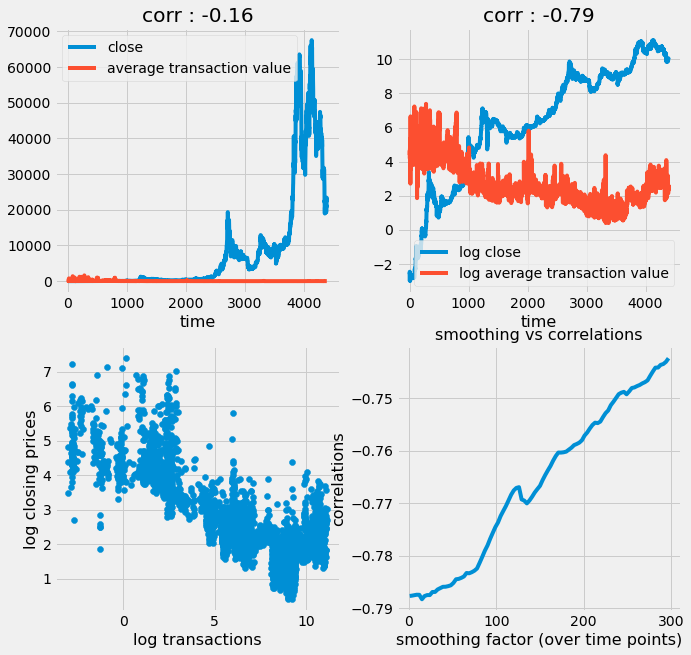

In [21]:
plot_log_comparison(df['close'],df['average_transaction_value'],'close','average transaction value');

###### scales did help

### all time increasing columns:

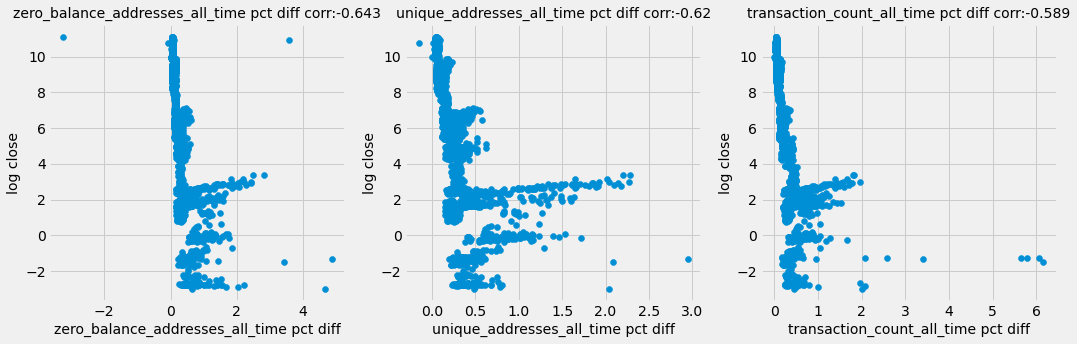

In [22]:
increasing_columns = ['zero_balance_addresses_all_time','unique_addresses_all_time','transaction_count_all_time']
increasing_series = [df[col].pct_change()*100 for col in increasing_columns]
names = [col+' pct diff' for col in increasing_columns]
fig,axes = plot_scatters_against(np.log(df['close']),increasing_series,'log close',names)

### active addresses <a class="anchor" name="active-addresses"></a>

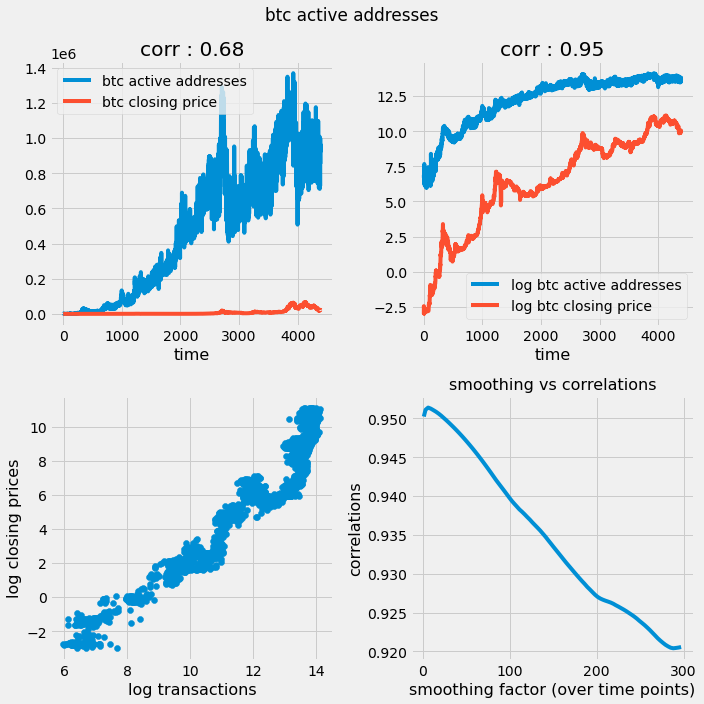

In [23]:
fig, axes = plot_log_comparison(df['active_addresses'],df['close'], 'btc active addresses','btc closing price')
plt.suptitle('btc active addresses')
plt.tight_layout()

## blockchain data: <a class="anchor" name="blockchain-data"></a>

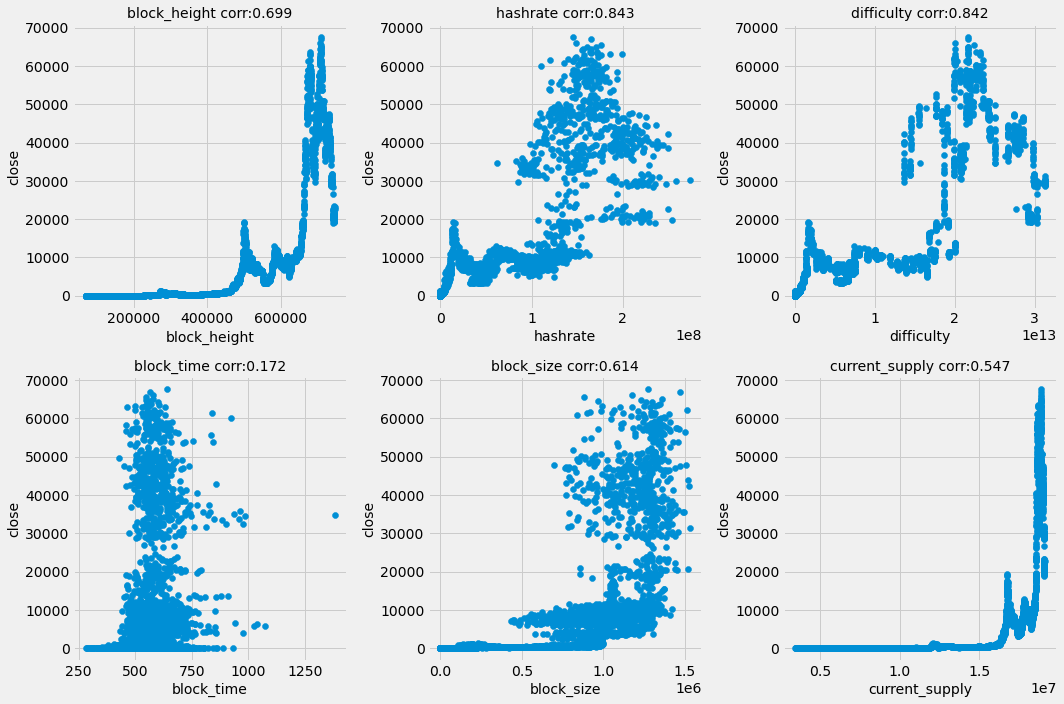

In [24]:
chain_columns = ['block_height', 'hashrate', 'difficulty','block_time', 'block_size', 'current_supply']
chain_series = [df[col] for col in chain_columns]
fig,axes = plot_scatters_against(df['close'],chain_series,'close',chain_columns) #TODO

##### most of the blockchain data features (e.g. hashrate, difficulty) are all somewhat a consequence of whats happening on the market, not sure currently if these can be used for prediction. Will return to this.

## Social data <a class="anchor" name="social-data"></a>

In [10]:
# first values:
first_non = df['reddit_posts_per_day'].first_valid_index()
reddit_columns =df.iloc[first_non-3:first_non+3].filter(regex='reddit').columns.tolist()
df.loc[first_non-3:first_non+3, ['time'] + reddit_columns]

,time,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day
2386,2017-01-27,NaN,NaN,NaN,NaN,NaN,NaN
2387,2017-01-28,NaN,NaN,NaN,NaN,NaN,NaN
2388,2017-01-29,NaN,NaN,NaN,NaN,NaN,NaN
2389,2017-01-30,0.0,0.0,0.0,0.0,0.0,0.0
2390,2017-01-31,0.0,0.0,0.0,0.0,0.0,0.0
2391,2017-02-01,0.0,0.0,0.0,0.0,0.0,0.0
2392,2017-02-02,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
plot_scatters_against(df['close'],[df[col] for col in reddit_columns],'close',reddit_columns);

NameError: name 'np' is not defined

##### all seem similar

In [16]:
from sklearn.decomposition import PCA
pca_social = df.filter(regex='reddit').iloc[first_non:]
print('columns originally:', len(pca_social.columns))
preserved_variance=0.9
pca = PCA(n_components=preserved_variance)
pca.fit((pca_social-pca_social.mean())/pca_social.std())
print('gained PC variance ratios:',pca.explained_variance_ratio_, 'with sum ',sum(pca.explained_variance_ratio_))

columns originally: 6
gained PC variance ratios: [0.6489834  0.19982645 0.0897565 ] with sum  0.9385663514634749


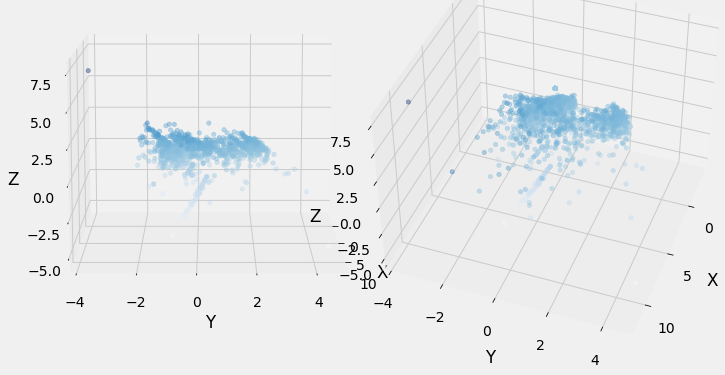

In [28]:
transformed_pca_social = pca.transform((pca_social-pca_social.mean())/pca_social.std())



plt.style.use("fivethirtyeight")
fig, axes = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection='3d'))
for idx,ax in enumerate(axes):
    ax.view_init(elev=10+idx*30, azim=idx*20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.dist=7
    ax.scatter3D(transformed_pca_social[:,0], transformed_pca_social[:,1], transformed_pca_social[:,2], c=transformed_pca_social[:,2], cmap='Blues',alpha=0.4)

In [40]:

def asd() -> 'asd':
    return 2

s = asd()
s

2

In [41]:
a = [...]
print(a)

[Ellipsis]


In [42]:
a.append(4)
a

[Ellipsis, 4]